## README 

Set the following `path` parameter to the path where the output of `fcbm.py` have been dumped. 

Most of the code in this notebook is conceived for pareto/power-law fitness distributions -- in fact, it makes plots with a power-law fit.
The `alpha` parameter specified in `plot_degree_distribution_with_fit` is just meant to make a nice legend and it must be set equal to `b+1` where `b` is the parameter of the pareto distribution used for the fitness.

### Import statements, macros, functions ###

In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import igraph
import powerlaw
from collections import Counter
import os
######
# from lib.lib_powerlaw import * # powerlaw_generator, plot_distribution_with_fit
# from lib.lib_social_mixing import compare_mixing
# from netzer.lib.centrallib import global_metrics

In [2]:
#### MACROS ####
path = './'

In [3]:
### Functions to compare the distributions graphically ###

def get_dist(data):
    data = sorted(data)
    xdata = []
    ydata = []
    x = data[0]
    y = 1
    i = 1
    l = len(data)
    while(i<l):
        xnew = data[i]
        if xnew == x:
            y += 1
        else:
            xdata.append(x)
            ydata.append(y/l)
            x = xnew
            y = 1
        i += 1
    xdata.append(x)
    ydata.append(y/l)
    return xdata, ydata


def get_fit_dist(alpha, xmin, xmax, scale):
    xfit = np.linspace(xmin,xmax,num=100)
    beta = (alpha-1)/(xmin**(1-alpha)-xmax**(1-alpha)) * scale
    yfit = beta*xfit**(-alpha)
    return xfit, yfit


def fit_data(data, xmin=None, xmax=None, compare=False, plot=False, discrete=True, output_file='', verbose=False):
    ''' fit data to a power law

        Args:
            data            is the distribution to fit, can be either a list or a dictionary
                            if a list, is interpreted as the list of all outcomes (e.g., [0,1,2,1,1] means pr(0)=pr(2)=0.2, pr(1)=0.6)
                            if a dictionary, items are interpreted as outcome:number_of_occurrences (e.g., {0:1, 1:3, 2:1})
            xmin
            xmax
            compare         another distribution to which the power law fit can be compared; if True or invalid, exponential is used 
            plot            specifies whether the fit must be plotted (both pdf fit and ccdf fit are plotted)
            output_file     the output file for the plot; if empty a default name is used
    '''
    if isinstance(data,dict):
        d = []
        for k,v in data.items():
            d += [k]*v
        data = np.array(d)
    else:
        data = np.array(data)

    fit = powerlaw.Fit(data=data, discrete=discrete, xmin=xmin, xmax=xmax, linear_bins=True)
    if verbose:
        print('Power-law best fit to data:')
        print('\t alpha = {}'.format(fit.power_law.alpha))
        print('\t sigma = {}'.format(fit.power_law.sigma))
        print('\t xmin = {}'.format(fit.power_law.xmin))
        print('\t xmax = {}'.format(fit.power_law.xmax))
    if compare:
        if compare == True:
            R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio = True)
        else:
            try:
                R, p = fit.distribution_compare('power_law', compare, normalized_ratio=True)
            except:
                print('the argument to option "compare" is not a valid distribution, will use exponential')
                R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio = True)
        if verbose:
            print('Normalized loglikelihood ratio: {}'.format(R))
            print('Significance value: {}'.format(p))
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
        fit.plot_pdf(color= 'b', ax=ax, label='data pdf')
        fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit pdf', ax=ax)
        fit.plot_ccdf(color='r', ax=ax, label='data ccdf')
        fit.power_law.plot_ccdf(color='r', linestyle='--', ax=ax, label='fit ccdf')
        plt.legend()
        if not output_file:
            output_file = 'power_law_fit.png'
        fig.savefig(output_file)
    return fit


def plot_degree_distribution_with_fit(data, plot_to=None, directed=False, title=None, alpha=None):

    if directed:
        plot_degree_distribution_with_fit({k:v for k,v in data.items() if 'out' in k}, plot_to='outdegree_distribution.png', title='out-degree distribution', alpha=alpha)
        plot_degree_distribution_with_fit({k:v for k,v in data.items() if 'in' in k}, plot_to='indegree_distribution.png', title='in-degree distribution', alpha=alpha)
    else:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.set_xscale('log')
        ax.set_yscale('log')

        for k,d in data.items():
            #### scatter plot of data distribution ####
            d = np.array(d)
            xdata, ydata = get_dist(d)

            if xdata[0]==0:
                prob0 = '={:.3f})'.format(ydata[0])
            else:
                prob0 = '=0)'

            # ax.scatter(xdata, ydata, s=80, alpha=0.4, label=f'{k} (' + r'$\Pr[0]$' + prob0)
            lab = f'{k}'
            if alpha and 'fitness' in lab:
                lab += ' (PL with '+ r'$\alpha$' + f'={alpha})'
            ax.scatter(xdata, ydata, s=80, alpha=0.4, label=lab)
            ymindata = min(ydata)

            fit = fit_data(d, discrete=True, compare=True, verbose=False)
            alpha = fit.alpha
            sigma = fit.sigma
            D     = fit.D
            xmin  = fit.xmin
            xmax = xdata[-1]
            scale = sum(ydata[xdata.index(xmin):xdata.index(xmax)])
            xfit, yfit = get_fit_dist(alpha, xmin, xmax, scale)

            # ymindata = min(ymindata, yminfib)
            xfit = xfit[yfit>=ymindata]
            yfit = yfit[yfit>=ymindata]
            ax.plot(xfit, yfit, '--', label=f'PL fit of {k} (' + r'$\alpha$' +'={:.2f})'.format(alpha))

            print("\n")
            print("-"*80)
            print(f"FIT DATA for {k}:")
            print("-"*80)
            print("alpha = {}, sigma = {}, D = {}".format(alpha, sigma, D))
            print("xmin = {}, xmax = {}".format(xmin, xmax))
            #print("yfit: ", yfit)
            #print("ylim bottom = ", ylimbottom)
            print("-"*80)
            print("\n")

        if title is None:
            title = 'degree distribution'
        ax.set_title(title, fontsize=25)
        ax.legend(loc='best', prop={'size': 12})
        ax.tick_params(labelsize=18)
        ax.set_ylabel('Probability', fontsize=20)
        ax.set_xlabel('Degree', fontsize=20)

        if plot_to is None:
            outfile = 'degree_distribution.png'
        else:
            outfile = plot_to
        fig.savefig(outfile, bbox_inches='tight') #, dpi=150)
        print("plot_distribution_with_fit: plot saved to {}".format(outfile))

    return


In [4]:
### Functions to generate the synthetic retweet network ###

def set_starters(g, n_tweets=1000):
    '''
    g is the directed friendship graph (u->v means that u is a follower of v's)
    n_tweets is the total number of synthetic tweets that must be generated
    the seeds are selected proportionally to their indegree (number of followers)
    for other approaches change this function accordingly
    '''
    d = np.asarray(g.indegree())
    d = d/d.sum()
    return np.random.choice(range(g.vcount()), size=n_tweets, p=d)

def get_retweeters(g, s, p):
    '''
    g is the directed friendship graph (u->v means that u is a follower of v's)
    s is the seed node (tweet author)
    p is an array of probabilities such that p[i] is the probability that users at distance i-1 from s retweet s
    this assumes that the retweeting probability only depends on the graph distance
    for other approaches change this function accordingly
    '''
    retweeters = []
    for i,x in enumerate(p):
        followers = np.asarray(g.neighborhood(s, order=i+1, mode='in', mindist=1))
        retweeters.extend((followers[np.random.random(len(followers))<x]).tolist())
    return retweeters

def create_retweet_network(g, n_tweets=1000, p=[0.1,0.05]):
    '''
    g is the directed friendship graph (u->v means that u is a follower of v's)
    n_tweets is the total number of synthetic tweets that must be generated, as used in set_starters
    p is an array of probabilities such that p[i] is the probability that users at distance i-1 from s retweet s, as used in get_retweeters
    '''
    starters = set_starters(g, n_tweets)
    edges = []
    for s in starters:
        retweeters = get_retweeters(g, s, p)
        edges.extend([(r,s) for r in retweeters])
    RN = igraph.Graph(g.vcount(), edges=edges, directed=True)
    return RN

### Read the real retweet network and possibly extract a subgraph of the desired size ###

In [5]:
# read retweet network with clusters
real_network_with_clusters = igraph.read(path+'retweet_graph_with_clusters.pickle')
cluster_type = '$V$' # check real_network_with_clusters.vertex_attributes() for alternatives
name2cluster = {v['name']:v[cluster_type] for v in real_network_with_clusters.vs}

In [6]:
#### to use the entire network, you can ignore what follows and just set:
# real_retweet_network = real_network_with_clusters

### otherwise:
# read original data
retweets = pd.read_csv(path+'retweet_network_edges.csv')
retweets = retweets.astype('str')
# select size of the sample
nusers = 1000
ntweets = 1000
# extract a set of users proportionally to their degree in the entire network 
all_users = retweets['# source'].tolist()+retweets['target'].tolist()
vc = Counter(all_users)
ids = list(vc.keys())
p = np.asarray(list(vc.values()))
p = p/p.sum()
ids = np.random.choice(ids, size=nusers, replace=False, p=p)
# select only the retweets made by those users, and a random sample of such retweets
myretweets = retweets[retweets['# source'].isin(ids) & retweets['target'].isin(ids)]
vc = myretweets['tweet_id'].value_counts()
twids = list(vc.keys())
p = np.asarray(list(vc.values))
p = p/p.sum()
twids = np.random.choice(twids, size=ntweets, replace=False, p=p)
myretweets = myretweets[myretweets['tweet_id'].isin(twids)]
# build the retweet network that only involved those retweets and users
i = 0
nodes = {}
names = []
edges = []
twids = []
for s,t,twid in myretweets.values:
    if s in nodes:
        sid = nodes[s]
    else:
        nodes[s] = i
        sid = i
        names.append(s)
        i += 1
    if t in nodes:
        tid = nodes[t]
    else:
        nodes[t] = i
        tid = i
        names.append(t)
        i += 1
    edges.append((sid,tid))
    twids.append(twid)
real_retweet_network = igraph.Graph(i, edges=edges, directed=True)
real_retweet_network.es['tweet_id'] = twids
real_retweet_network.vs['name'] = names

In [7]:
# take the giant component
real_retweet_network = real_retweet_network.components('WEAK').giant()

In [8]:
# add labels
real_retweet_network.vs['cluster'] = [name2cluster.get(v['name'],-1) for v in real_retweet_network.vs]

In [9]:
# print info
real_retweet_network.summary()

'IGRAPH DN-- 724 14438 -- \n+ attr: cluster (v), name (v), tweet_id (e)'

### REMARK
From `real_retweet_network` you should extract some of the parameters needed to run `fcbm.py`, namely:
- the size N of the network
- the matrix DELTA, which can be computed counting the edges connecting each pair of clusters

The other parameters can be set looking at the number of followers of each user, extracted from the original json obtained from the APIs (ask Fabio)
- the density of the network P can be set equal to the average number of followers of the users in the dataset, multiplied by the total number of users in the dataset over the total number of users of Twitter Italia
- the in-fitness distribution can be set fitting a pareto to the distribution of the number of followers
- the out-fitness distribution can be set fitting a pareto to the distribution of the number of followees

The rest of the notebook assumes that `fcbm.py` has already been run and the output files have been moved to the working folder specified by the `path` variable.

### Make plots to verify the degree distribution of the synthetic friendship graph ###

In [10]:
# read data dumped by fcbm.py with exact model
with open(path+'data_for_plots_FCBM_10_graphs_directed_exact.pickle', 'rb') as f:
    data = pickle.load(f)
# change some of the names
data['in-fitness'] = data['fitness_in']
del(data['fitness_in'])
data['out-fitness'] = data['fitness_out']
del(data['fitness_out'])
data['exact in-degree'] = data['exact in']
del(data['exact in'])
data['exact out-degree'] = data['exact out']
del(data['exact out'])

In [11]:
###### alternative for approximate model ######
# read data dumped by fcbm.py with exact model
# with open(path+'data_for_plots_FCBM_10_graphs_directed_approx.pickle', 'rb') as f:
#     data = pickle.load(f)
# change some of the names
# data['in-fitness'] = data['fitness_in']
# del(data['fitness_in'])
# data['out-fitness'] = data['fitness_out']
# del(data['fitness_out'])
# data['sparse in-degree'] = data['appr. in']
# del(data['appr. in'])
# data['sparse out-degree'] = data['appr. out']
# del(data['appr. out'])

Calculating best minimal value for power law fit
xmin progress: 98%

--------------------------------------------------------------------------------
FIT DATA for out-fitness:
--------------------------------------------------------------------------------
alpha = 2.4599472302718572, sigma = 0.06420840577150709, D = 0.016191577252076317
xmin = 6.0, xmax = 245.0
--------------------------------------------------------------------------------


Calculating best minimal value for power law fit
xmin progress: 99%

--------------------------------------------------------------------------------
FIT DATA for exact out-degree:
--------------------------------------------------------------------------------
alpha = 2.5249811268003253, sigma = 0.02259789340542652, D = 0.01593890389326924
xmin = 7.0, xmax = 298
--------------------------------------------------------------------------------




Values less than or equal to 0 in data. Throwing out 0 or negative values


plot_distribution_with_fit: plot saved to outdegree_distribution.png
Calculating best minimal value for power law fit
xmin progress: 98%

--------------------------------------------------------------------------------
FIT DATA for in-fitness:
--------------------------------------------------------------------------------
alpha = 2.398365388119654, sigma = 0.04994162100427335, D = 0.017293264754906224
xmin = 4.0, xmax = 1088.0
--------------------------------------------------------------------------------


Calculating best minimal value for power law fit
xmin progress: 99%

--------------------------------------------------------------------------------
FIT DATA for exact in-degree:
--------------------------------------------------------------------------------
alpha = 2.337577046199458, sigma = 0.05320595811251179, D = 0.022284653918214214
xmin = 22.0, xmax = 824
--------------------------------------------------------------------------------




Values less than or equal to 0 in data. Throwing out 0 or negative values


plot_distribution_with_fit: plot saved to indegree_distribution.png


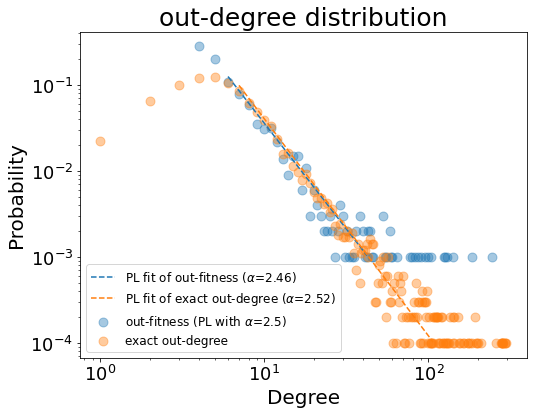

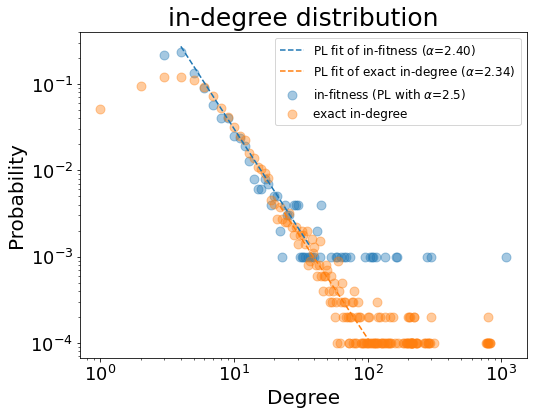

In [12]:
plot_degree_distribution_with_fit(data, directed=True, alpha=2.5)

### Create the synthetic retweet network ###

In [13]:
with open(path+'graphs_exact_FCBM_directed.pickle', 'rb') as f:
    graphs = pickle.load(f)
# alternative for approximate model:
# with open(path+'graphs_approx_FCBM_directed.pickle', 'rb') as f:
#     graphs = pickle.load(f)

In [14]:
# select one of the dumped friendship networks
g = graphs[0]

In [15]:
# create the retweet network
RN = create_retweet_network(g, p=[0.1,0.01])

In [16]:
# only take the giant component
RN = RN.components('WEAK').giant()

In [17]:
# print RN info
RN.summary() #)

'IGRAPH D--- 993 14759 -- '

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
xmin progress: 97%

--------------------------------------------------------------------------------
FIT DATA for outdeg:
--------------------------------------------------------------------------------
alpha = 4.918914112233267, sigma = 0.2850590565292002, D = 0.017949830226422825
xmin = 21.0, xmax = 57
--------------------------------------------------------------------------------


plot_distribution_with_fit: plot saved to outdegree_distribution.png
Calculating best minimal value for power law fit
xmin progress: 97%

--------------------------------------------------------------------------------
FIT DATA for indeg:
--------------------------------------------------------------------------------
alpha = 1.7684197296892106, sigma = 0.05589431074283036, D = 0.036983741960630034
xmin = 3.0, xmax = 7839
--------------------------------------------------------------------------------




Values less than or equal to 0 in data. Throwing out 0 or negative values


plot_distribution_with_fit: plot saved to indegree_distribution.png


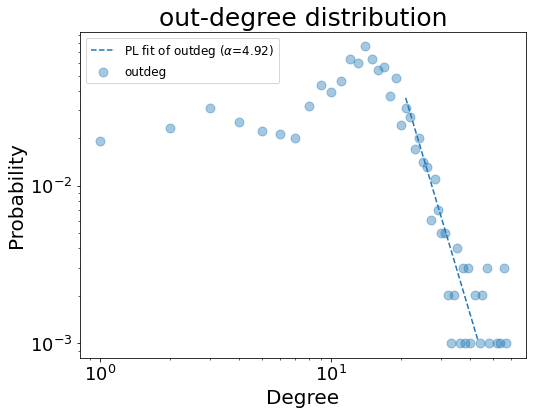

In [18]:
# plot degree distributions
plot_degree_distribution_with_fit({'indeg':RN.indegree(),'outdeg':RN.outdegree()}, directed=True, plot_to='synthetic')

### compare the two networks ###

In [19]:
metrics = {'real retweet network':{}}
metrics['real retweet network']['C_g'] = real_retweet_network.transitivity_undirected()
metrics['real retweet network']['C_l'] = real_retweet_network.transitivity_avglocal_undirected()
metrics['real retweet network']['k_in'] = np.mean(real_retweet_network.indegree())
metrics['real retweet network']['k_out'] = np.mean(real_retweet_network.outdegree())

In [20]:
metrics['synthetic retweet network'] = {}
metrics['synthetic retweet network']['C_g'] = RN.transitivity_undirected()
metrics['synthetic retweet network']['C_l'] = RN.transitivity_avglocal_undirected()
metrics['synthetic retweet network']['k_in'] = np.mean(RN.indegree())
metrics['synthetic retweet network']['k_out'] = np.mean(RN.outdegree())

In [21]:
metrics = pd.DataFrame(metrics).transpose()

In [22]:
metrics = metrics.rename(columns={'C_g':'global clustering', 'C_l':'average local clustering', 'k_in':'average in-degree', 'k_out':'average out-degree'})

In [23]:
print(metrics.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  global clustering &  average local clustering &  average in-degree &  average out-degree \\
\midrule
real retweet network      &           0.144207 &                  0.149087 &          19.941989 &           19.941989 \\
synthetic retweet network &           0.026108 &                  0.505394 &          14.863041 &           14.863041 \\
\bottomrule
\end{tabular}



<ipython-input-23-1cccc741f2da>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metrics.to_latex())


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
xmin progress: 99%

--------------------------------------------------------------------------------
FIT DATA for real out-degree:
--------------------------------------------------------------------------------
alpha = 1.9768413743862676, sigma = 0.100221810354142, D = 0.08564438611359321
xmin = 34.0, xmax = 902
--------------------------------------------------------------------------------


Calculating best minimal value for power law fit
xmin progress: 97%

--------------------------------------------------------------------------------
FIT DATA for synthetic out-degree:
--------------------------------------------------------------------------------
alpha = 4.918914112233267, sigma = 0.2850590565292002, D = 0.017949830226422825
xmin = 21.0, xmax = 57
--------------------------------------------------------------------------------


plot_distribution_with_fit: plot saved to outdegree_distribution.png
Calculating best minimal value f

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


plot_distribution_with_fit: plot saved to indegree_distribution.png


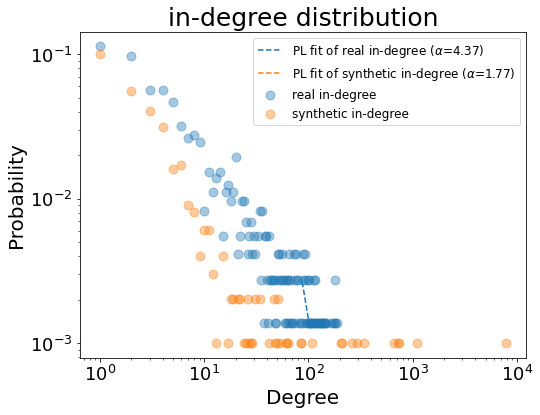

In [24]:
toplot = {'real in-degree':real_retweet_network.indegree(),'real out-degree':real_retweet_network.outdegree(),
          'synthetic in-degree':RN.indegree(), 'synthetic out-degree':RN.outdegree()}
plot_degree_distribution_with_fit(toplot, directed=True, plot_to='comparison')